In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


### Reading the data from dataset.

In [4]:
data = pd.read_csv("car_price_prediction.csv")

In [5]:
data.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [6]:
print(data.shape)

data.info()

(19237, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-

### Data cleaning, pre-processing and exploring process.

In [7]:
# checking for duplicate values and removing them

data.duplicated().sum()

np.int64(313)

In [8]:
# since duplicate values are present, we will remove them

data.drop_duplicates(inplace= True)

In [9]:
# checking for missing values

data.isna().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

#### No missing values are present.

In [10]:
# checking the statistics of the data

data.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.892400e+04,1.892400e+04,18924.000000,18924.000000,18924.000000
mean,4.557538e+07,1.858744e+04,2010.914236,4.580216,6.568379
std,9.375468e+05,1.921356e+05,5.665749,1.200223,4.322323
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569501e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577191e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580174e+07,2.206300e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


#### Analysing each columns and checking unique values for each column:

In [11]:
for col in data.columns:
    print(f'All unique values in {col} is :\n {data[col].unique()}\n')


All unique values in ID is :
 [45654403 44731507 45774419 ... 45804997 45793526 45813273]

All unique values in Price is :
 [13328 16621  8467 ... 56814 63886 22075]

All unique values in Levy is :
 ['1399' '1018' '-' '862' '446' '891' '761' '751' '394' '1053' '1055'
 '1079' '810' '2386' '1850' '531' '586' '1249' '2455' '583' '1537' '1288'
 '915' '1750' '707' '1077' '1486' '1091' '650' '382' '1436' '1194' '503'
 '1017' '1104' '639' '629' '919' '781' '530' '640' '765' '777' '779' '934'
 '769' '645' '1185' '1324' '830' '1187' '1111' '760' '642' '1604' '1095'
 '966' '473' '1138' '1811' '988' '917' '1156' '687' '11714' '836' '1347'
 '2866' '1646' '259' '609' '697' '585' '475' '690' '308' '1823' '1361'
 '1273' '924' '584' '2078' '831' '1172' '893' '1872' '1885' '1266' '447'
 '2148' '1730' '730' '289' '502' '333' '1325' '247' '879' '1342' '1327'
 '1598' '1514' '1058' '738' '1935' '481' '1522' '1282' '456' '880' '900'
 '798' '1277' '442' '1051' '790' '1292' '1047' '528' '1211' '1493' '1793'
 

#### Removing ID and doors column which may affect the modal since it is not that significant:

In [12]:
data = data.drop(["ID", "Doors"], axis=1)

In [13]:
data.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,Left wheel,Black,8
2,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,Right-hand drive,Black,2
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,Left wheel,White,0
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,Left wheel,Silver,4


#### Since Levy column has '-' which might be a useless data value, we will convert it to 0 and type of the column to float:

In [14]:
data['Levy']=data['Levy'].replace('-','0')

data['Levy'] = data['Levy'].astype('float64')

#### Converting Prod. year to be age of the car instead since it will be easier to deal to with instead of the year of production since it also has a impact on a vehicle price:

In [15]:
current_date = dt.datetime.now()

data["Age"] = current_date.year - data["Prod. year"]

data = data.drop("Prod. year", axis=1)

In [16]:
data.head()

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags,Age
0,13328,1399.0,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,Left wheel,Silver,12,14
1,16621,1018.0,CHEVROLET,Equinox,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,Left wheel,Black,8,13
2,8467,0.0,HONDA,FIT,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,Right-hand drive,Black,2,18
3,3607,862.0,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,Left wheel,White,0,13
4,11726,446.0,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,Left wheel,Silver,4,10


#### Converting mileage to an integer value and removing "km":

In [17]:
data["Mileage"] = data["Mileage"].str.replace("km", "")

data.Mileage = data.Mileage.astype("Int64")

print(data["Mileage"])

0        186005
1        192000
2        200000
3        168966
4         91901
          ...  
19232    300000
19233    161600
19234    116365
19235     51258
19236    186923
Name: Mileage, Length: 18924, dtype: Int64


In [18]:
print(data["Engine volume"].unique())

['3.5' '3' '1.3' '2.5' '2' '1.8' '2.4' '4' '1.6' '3.3' '2.0 Turbo'
 '2.2 Turbo' '4.7' '1.5' '4.4' '3.0 Turbo' '1.4 Turbo' '3.6' '2.3'
 '1.5 Turbo' '1.6 Turbo' '2.2' '2.3 Turbo' '1.4' '5.5' '2.8 Turbo' '3.2'
 '3.8' '4.6' '1.2' '5' '1.7' '2.9' '0.5' '1.8 Turbo' '2.4 Turbo'
 '3.5 Turbo' '1.9' '2.7' '4.8' '5.3' '0.4' '2.8' '3.2 Turbo' '1.1' '2.1'
 '0.7' '5.4' '1.3 Turbo' '3.7' '1' '2.5 Turbo' '2.6' '1.9 Turbo'
 '4.4 Turbo' '4.7 Turbo' '0.8' '0.2 Turbo' '5.7' '4.8 Turbo' '4.6 Turbo'
 '6.7' '6.2' '1.2 Turbo' '3.4' '1.7 Turbo' '6.3 Turbo' '2.7 Turbo' '4.3'
 '4.2' '2.9 Turbo' '0' '4.0 Turbo' '20' '3.6 Turbo' '0.3' '3.7 Turbo'
 '5.9' '5.5 Turbo' '0.2' '2.1 Turbo' '5.6' '6' '0.7 Turbo' '0.6 Turbo'
 '6.8' '4.5' '0.6' '7.3' '0.1' '1.0 Turbo' '6.3' '4.5 Turbo' '0.8 Turbo'
 '4.2 Turbo' '3.1' '5.0 Turbo' '6.4' '3.9' '5.7 Turbo' '0.9' '0.4 Turbo'
 '5.4 Turbo' '0.3 Turbo' '5.2' '5.8' '1.1 Turbo']


#### Removing "turbo" keyword in Engine volume and converting it into a float type:

In [19]:
data["Engine volume"] = data["Engine volume"].str.replace("Turbo", "")

data["Engine volume"] = data["Engine volume"].astype("float64")

In [20]:
print(data["Engine volume"].unique())

[ 3.5  3.   1.3  2.5  2.   1.8  2.4  4.   1.6  3.3  2.2  4.7  1.5  4.4
  1.4  3.6  2.3  5.5  2.8  3.2  3.8  4.6  1.2  5.   1.7  2.9  0.5  1.9
  2.7  4.8  5.3  0.4  1.1  2.1  0.7  5.4  3.7  1.   2.6  0.8  0.2  5.7
  6.7  6.2  3.4  6.3  4.3  4.2  0.  20.   0.3  5.9  5.6  6.   0.6  6.8
  4.5  7.3  0.1  3.1  6.4  3.9  0.9  5.2  5.8]


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             18924 non-null  int64  
 1   Levy              18924 non-null  float64
 2   Manufacturer      18924 non-null  object 
 3   Model             18924 non-null  object 
 4   Category          18924 non-null  object 
 5   Leather interior  18924 non-null  object 
 6   Fuel type         18924 non-null  object 
 7   Engine volume     18924 non-null  float64
 8   Mileage           18924 non-null  Int64  
 9   Cylinders         18924 non-null  float64
 10  Gear box type     18924 non-null  object 
 11  Drive wheels      18924 non-null  object 
 12  Wheel             18924 non-null  object 
 13  Color             18924 non-null  object 
 14  Airbags           18924 non-null  int64  
 15  Age               18924 non-null  int64  
dtypes: Int64(1), float64(3), int64(3), object(9)


### Visualizing and analyzing process


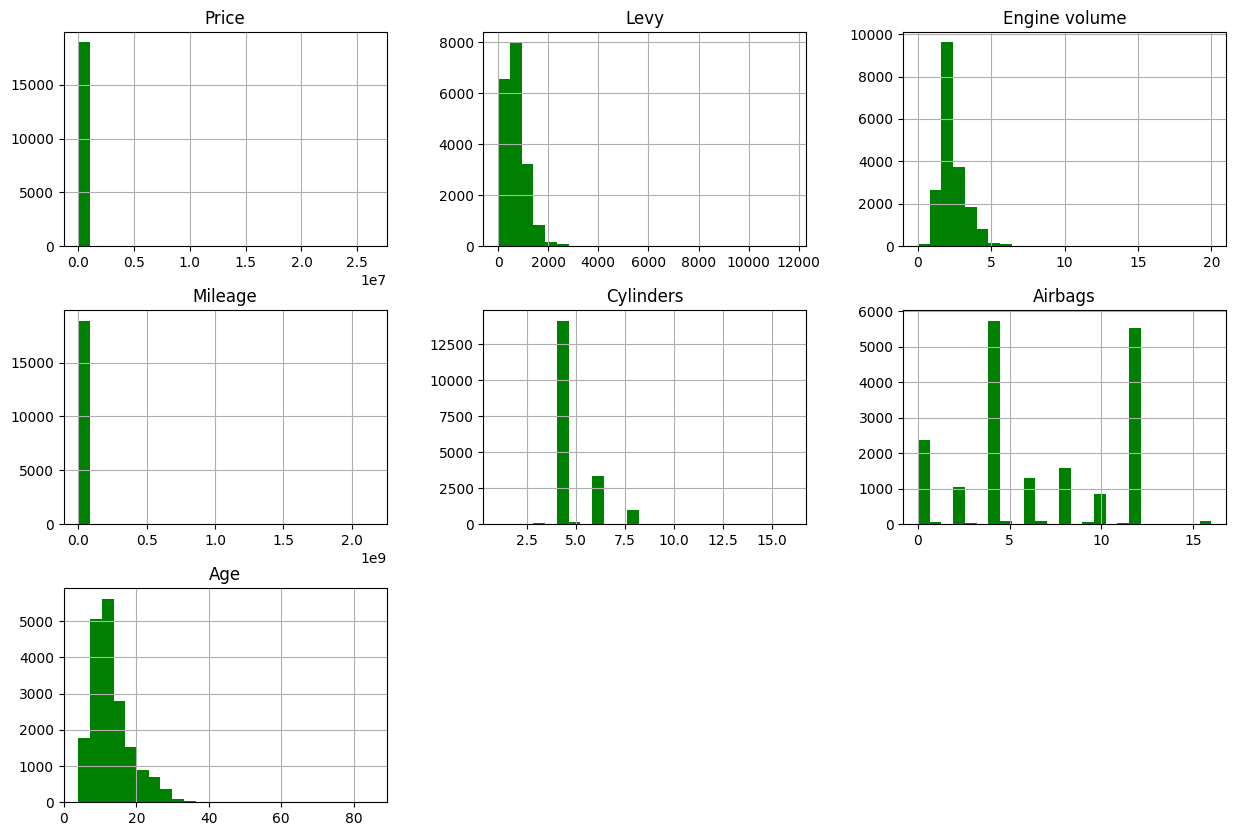

In [22]:
data.hist(bins=25,figsize=(15,10),color='green')
plt.show()

#### Observations:
1) Levy column is always between 0 and 2000.
2) Most cars are new because they have mileage of 0.
3) Most cars are 10 to 15 years old, majority being less than 20 years old.
4) Engine volumes is always in the range from 0 to 5.
5) Most cars have 4 cylinder engines.


#### Checking most frequent vehicle category:

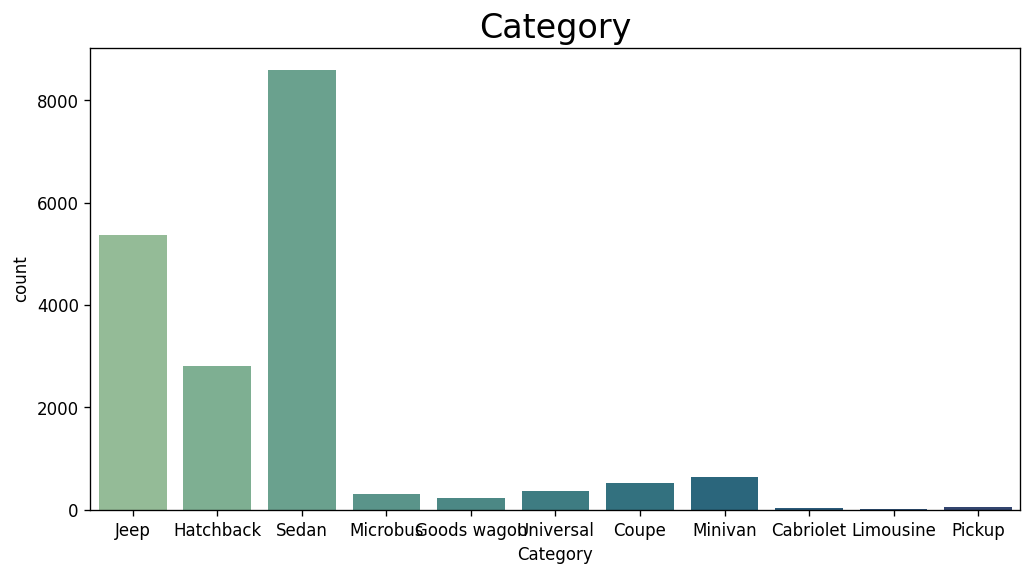

In [23]:
plt.subplots(figsize=(10,5), dpi=120)
sns.countplot(data= data, x='Category', palette='crest')
plt.title("Category",fontsize=20)
plt.show()

#### Sedan is majority, followed by hatchbacks and jeeps.

#### Checking the vechicle colors:

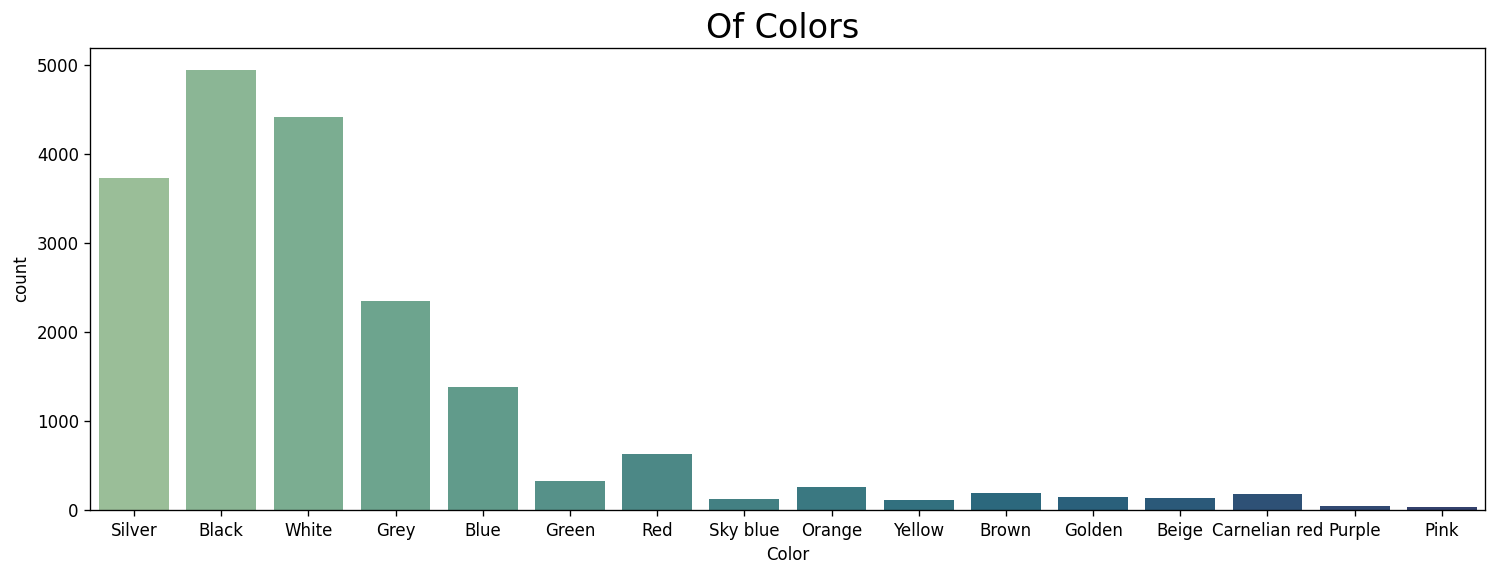

In [24]:
plt.subplots(figsize=(15,5), dpi=120)
sns.countplot(data= data, x='Color',palette='crest')
plt.title("Of Colors ",fontsize=20)
plt.show()

#### Most sold color type are black, silver, white and grey.

#### Checking most sold gear box type and fuel type:

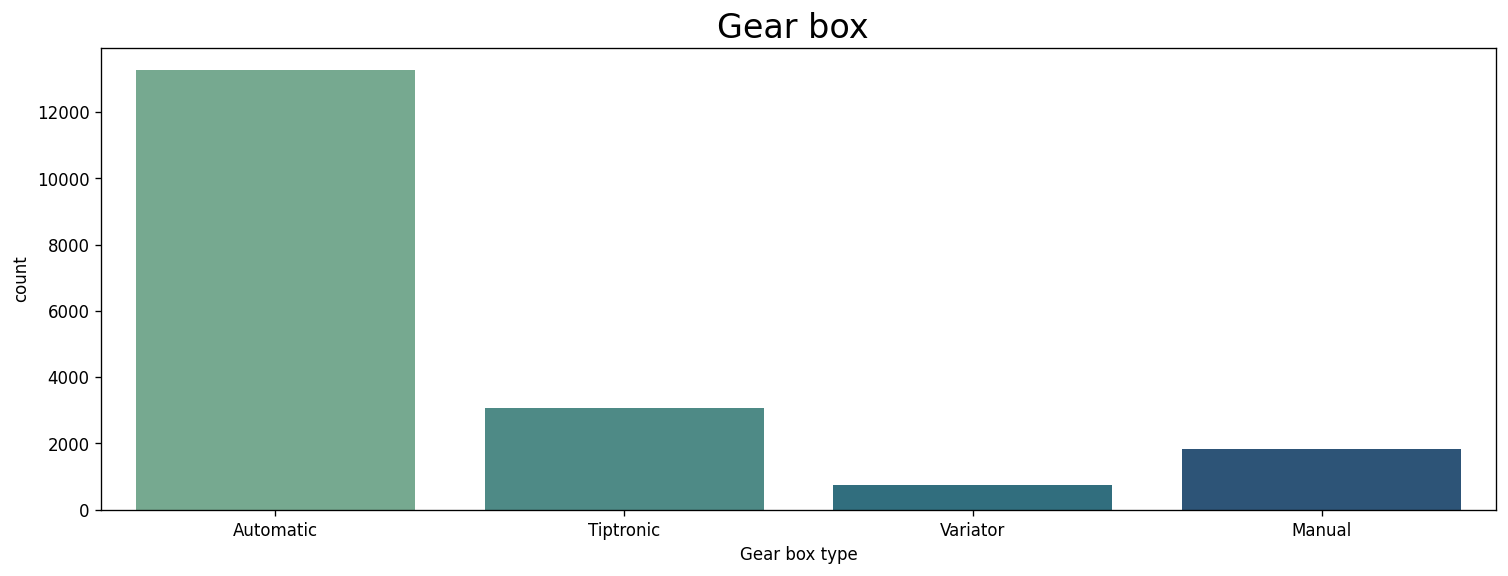

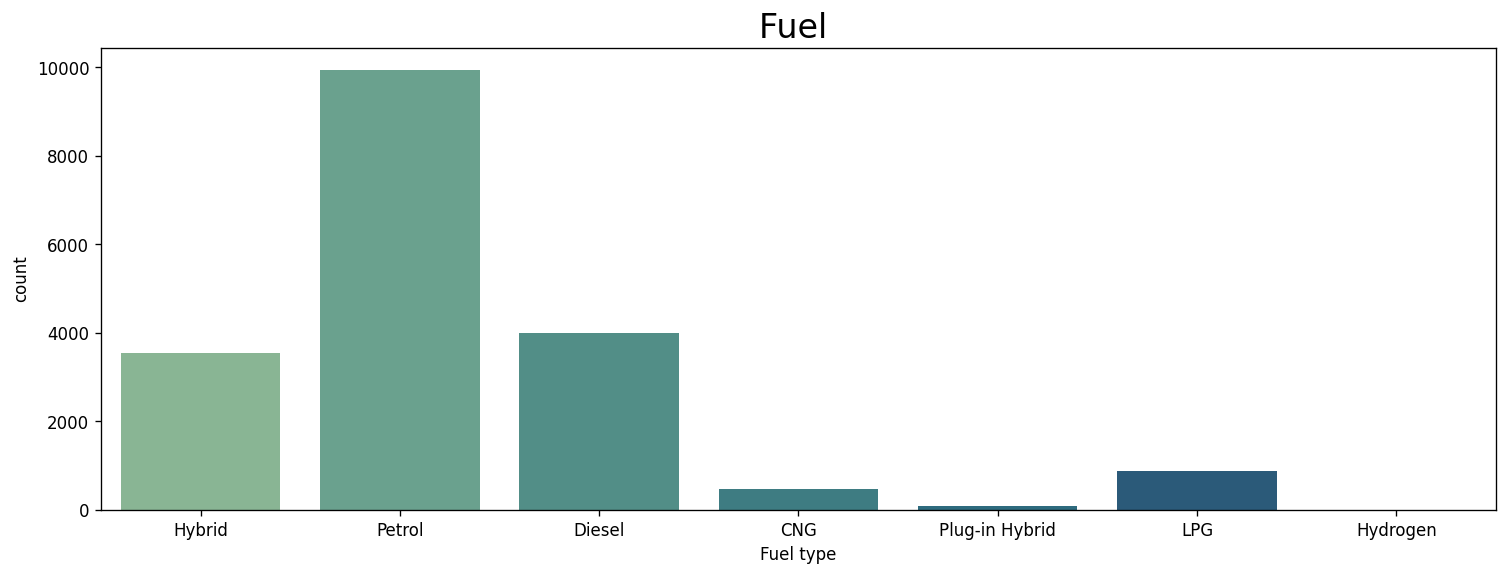

In [55]:
plt.subplots(figsize=(15,5), dpi=120)
sns.countplot(data= data, x='Gear box type',palette='crest')
plt.title("Gear box ",fontsize=20)
plt.show()

plt.subplots(figsize=(15,5), dpi=120)
sns.countplot(data= data, x='Fuel type',palette='crest')
plt.title("Fuel ",fontsize=20)
plt.show()

#### Most cars sold are automatic and uses petrol, while hybrid is closely with diesel engines.

#### Checking top 5 car manufactuers: 

Manufacturer
HYUNDAI          3729
TOYOTA           3606
MERCEDES-BENZ    2043
FORD             1088
CHEVROLET        1047
Name: count, dtype: int64


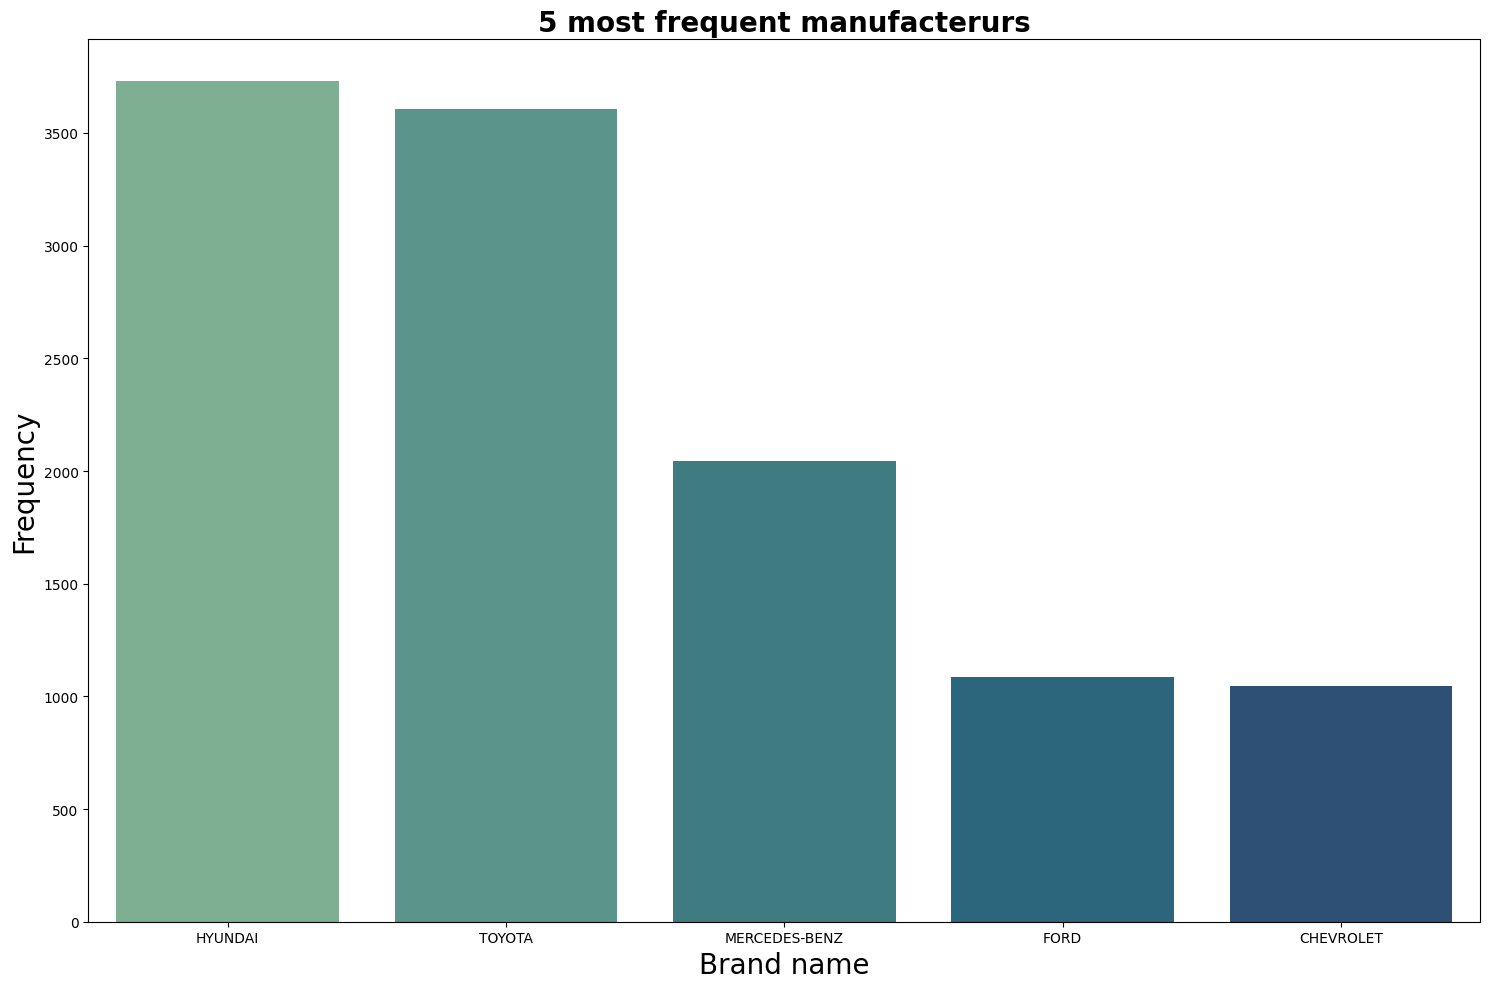

In [26]:
manufacterers = data.Manufacturer.value_counts().sort_values(ascending=False)[:5]

print(manufacterers)

plt.figure(figsize=(15, 10))
sns.barplot(x=manufacterers.index, y=manufacterers,palette='crest',linewidth = 4)
plt.title('5 most frequent manufacterurs',loc='center',fontweight='bold',fontsize=20)
plt.xlabel('Brand name',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.tight_layout()
plt.show()


#### Checking average price for top 5 car manufacturers:

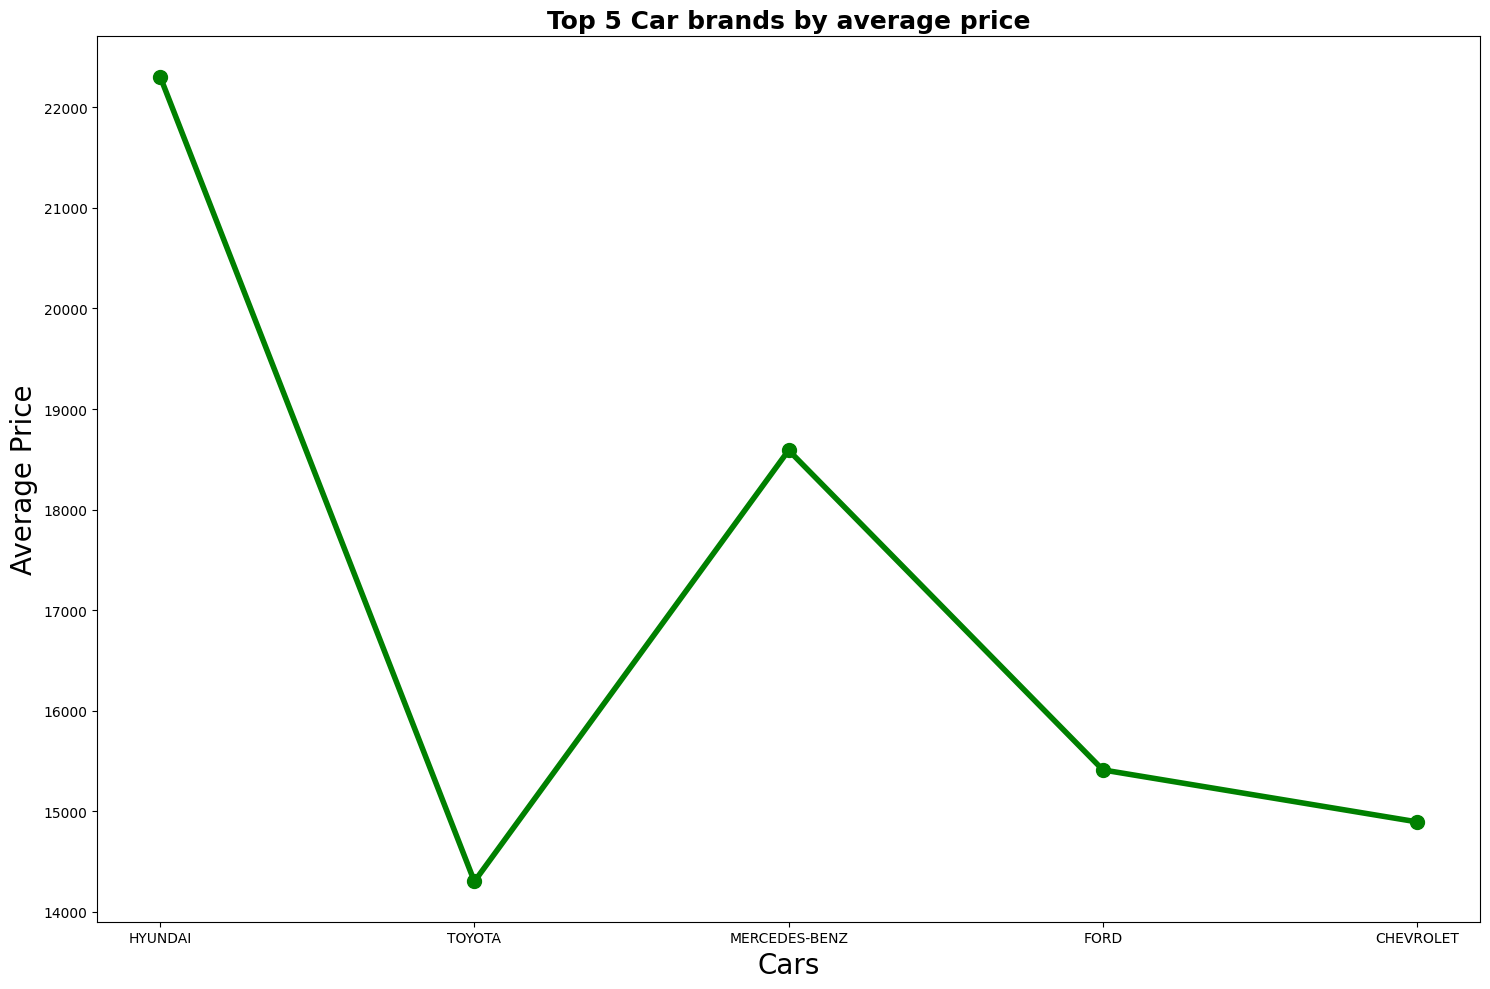

In [32]:
manufacterers_average_price = [data[data['Manufacturer']==i]['Price'].mean() for i in list(manufacterers.index)]

plt.figure(figsize=(15,10))
plt.plot(manufacterers.index, manufacterers_average_price,color='g',
         linewidth = 4, marker='o',markersize = 10)
plt.title('Top 5 Car brands by average price',loc='center',fontweight='bold',fontsize=18)
plt.ylabel('Average Price',fontsize=20)
plt.xlabel('Cars',fontsize=20)
plt.tight_layout()
plt.show()

In [36]:
data.head()

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags,Age
0,13328,1399.0,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,Left wheel,Silver,12,14
1,16621,1018.0,CHEVROLET,Equinox,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,Left wheel,Black,8,13
2,8467,0.0,HONDA,FIT,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,Right-hand drive,Black,2,18
3,3607,862.0,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,Left wheel,White,0,13
4,11726,446.0,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,Left wheel,Silver,4,10


<Axes: xlabel='Color', ylabel='Price'>

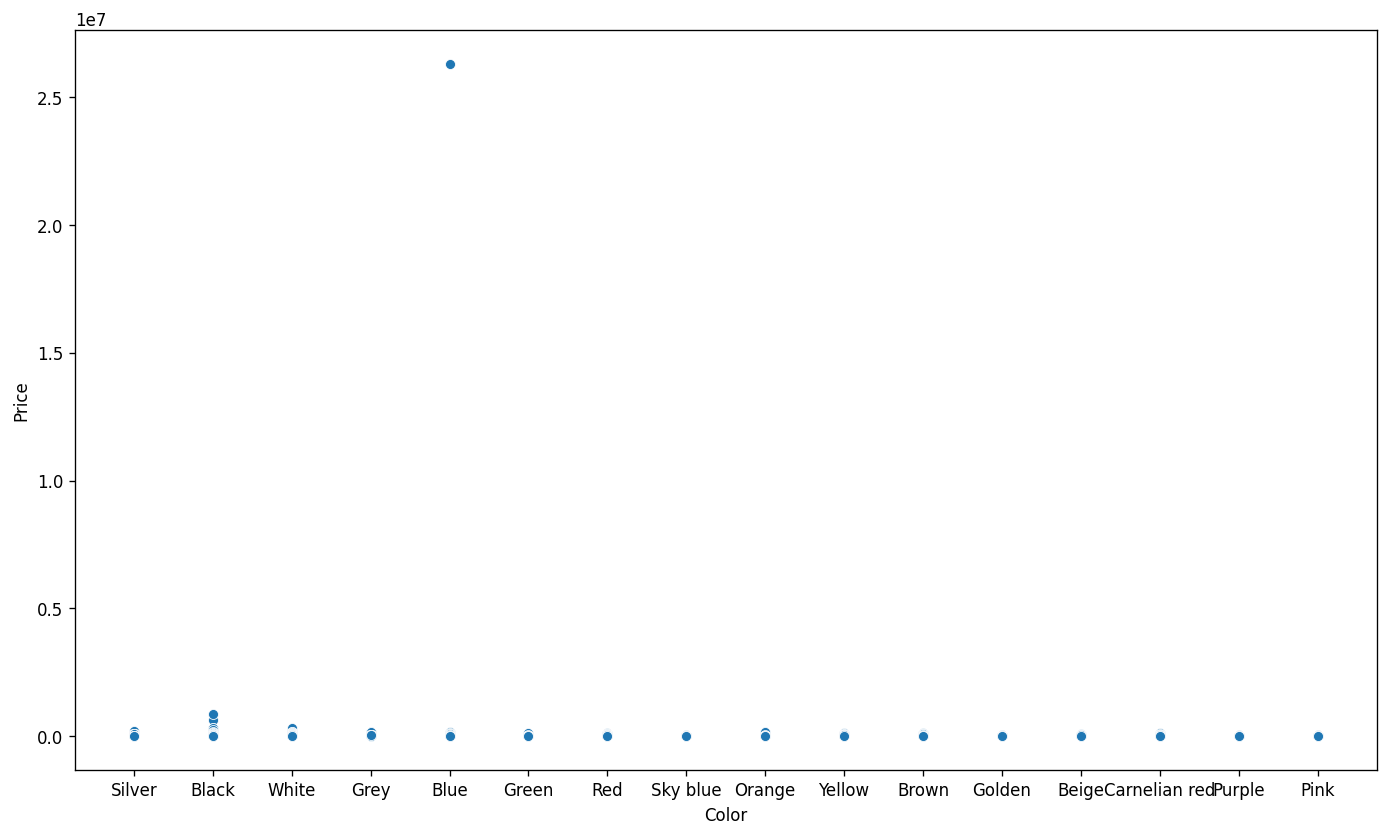

In [49]:
plt.figure(figsize=(14, 8), dpi=120)
sns.scatterplot(data=data, x='Color', y='Price', palette="crest")

#### Color dosen't seem to make any difference on a car's price.

#### Checking and visualizing correlation between numerical columns:

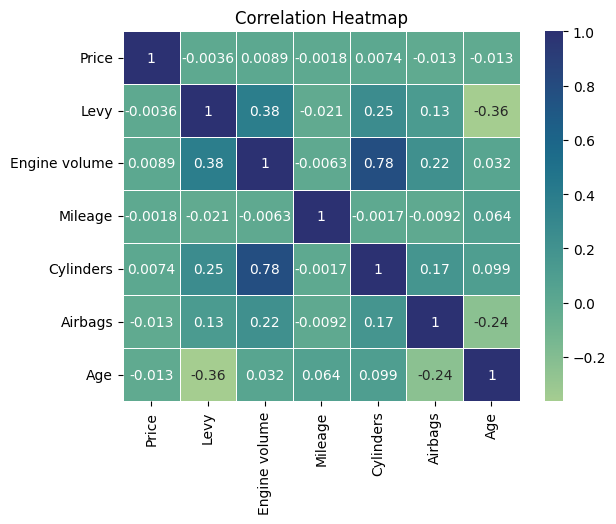

In [ ]:
correlation_data = data.select_dtypes(exclude=object).corr()

correlation_data

sns.heatmap(correlation_data, annot= True, linewidths= 0.4,cmap='crest')
plt.title('Correlation Heatmap')
plt.show()

### Outlier detection and removal process